<a href="https://colab.research.google.com/github/AnahitaNouri/Weather-Forecast/blob/main/Weather_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

###  Step 1: Load and Prepare the Weather Data

In this step, we load and preprocess the weather dataset to prepare it for time series forecasting.

1. **Load the dataset**
   - The CSV file `Weather_ts.csv` is loaded using `pandas.read_csv`.

2. **Parse datetime column**
   - The `'Date Time'` column is parsed using the European date format (`%d.%m.%Y %H:%M:%S`) and converted to `datetime` objects.
   - `dayfirst=True` ensures correct parsing when day and month positions could be ambiguous.

3. **Set datetime as index**
   - The `'Date Time'` column is set as the index of the DataFrame, which is essential for resampling and time-based slicing.

4. **Resample to weekly data**
   - The data is resampled to weekly frequency (`'W'`) using mean aggregation. This reduces the original high-frequency time series (likely 10-minute intervals) to weekly averages.

5. **Train-test split**
   - **Training data:** All weekly data from 2009 to 2015.
   - **Test data:** Weekly data from 2016.

6. **Handle missing values**
   - Missing values after resampling are identified and forward-filled (`ffill`) to ensure model compatibility.

7. **Shape confirmation**
   - The script prints the shapes of the training and test sets:
     - 📘 Train: 365 weeks
     - 📕 Test: 52 weeks

This processed dataset is now clean, regular (weekly), and ready for exploratory analysis and modeling.


In [ ]:
# Load data
file_path = '/content/Weather_ts.csv'
data = pd.read_csv(file_path)

# Convert 'Date Time' column to datetime (European format: DD.MM.YYYY)
data['Date Time'] = pd.to_datetime(
    data['Date Time'],
    format='%d.%m.%Y %H:%M:%S',  # Explicit format for European dates
    dayfirst=True                # Alternative approach (works with format='mixed')
)

# Set as index
data.set_index('Date Time', inplace=True)


# Resample to weekly frequency (mean aggregation)
weekly_data = data.resample('W').mean()

# Split into train (2009-2015) and test (2016)
train = weekly_data.loc['2009':'2015']
test = weekly_data.loc['2016']

# Add after resampling
print("Missing values per column after resampling:")
print(weekly_data.isnull().sum())

# Forward-fill small gaps if needed
weekly_data = weekly_data.ffill()

print(f"Train shape: {train.shape}, Test shape: {test.shape}")

# Correct weekly aggregation and splitting
weekly_data = data.resample('W').mean()  # 10-min → weekly
train = weekly_data.loc['2009':'2015']   # 7 years training
test = weekly_data.loc['2016']           # 1 year testing

print("=== COMPREHENSIVE DATASET OVERVIEW ===")
print(f"Dataset shape: {data.shape}")
print(f"Date range: {data.index.min()} to {data.index.max()}")
print(f"Total duration: {(data.index.max() - data.index.min()).days} days")
print(f"Number of features: {data.shape[1]}")
print("\nFeature names:")
for i, col in enumerate(data.columns, 1):
    print(f"{i:2d}. {col}")

# Comprehensive descriptive statistics for all features
print("\n=== DESCRIPTIVE STATISTICS FOR ALL FEATURES ===")
desc_stats = data.describe()
print(desc_stats.round(2))

# Focus on temperature as target variable
print(f"\n=== TEMPERATURE ANALYSIS ===")
temp_col = 'T (degC)'
print(f"Temperature range: {data[temp_col].min():.1f}°C to {data[temp_col].max():.1f}°C")
print(f"Temperature variance: {data[temp_col].var():.2f}")
print(f"Missing values in temperature: {data[temp_col].isnull().sum()}")

Missing values per column after resampling:
p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64
Train shape: (365, 14), Test shape: (52, 14)
=== COMPREHENSIVE DATASET OVERVIEW ===
Dataset shape: (420550, 14)
Date range: 2009-01-01 00:10:00 to 2016-12-31 23:50:00
Total duration: 2921 days
Number of features: 14

Feature names:
 1. p (mbar)
 2. T (degC)
 3. Tpot (K)
 4. Tdew (degC)
 5. rh (%)
 6. VPmax (mbar)
 7. VPact (mbar)
 8. VPdef (mbar)
 9. sh (g/kg)
10. H2OC (mmol/mol)
11. rho (g/m**3)
12. wv (m/s)
13. max. wv (m/s)
14. wd (deg)

=== DESCRIPTIVE STATISTICS FOR ALL FEATURES ===
        p (mbar)   T (degC)   Tpot (K)  Tdew (degC)     rh (%)  VPmax (mbar)  \
count  420550.00  420550.00  420550.00    420550.00  420550.00     420550.00

### Step 3: Time Series Diagnostics – Correlation, Stationarity, and Seasonality

This step evaluates the temperature time series to ensure it's suitable for ARIMA/SARIMA modeling:

-  **Correlation Plot:** Shows how strongly other features relate to temperature. Useful for interpretation, especially in multivariate settings.
-  **ADF Test:** Confirms the series is stationary (p-value = 0.0000), so no differencing is needed.
- **Seasonality Strength:** A high ratio (0.80) indicates strong seasonal patterns, justifying the use of SARIMA.

These checks validate that the data is ready for seasonal time series modeling.


ADF p-value: 0.0000
Seasonality strength ratio: 0.80


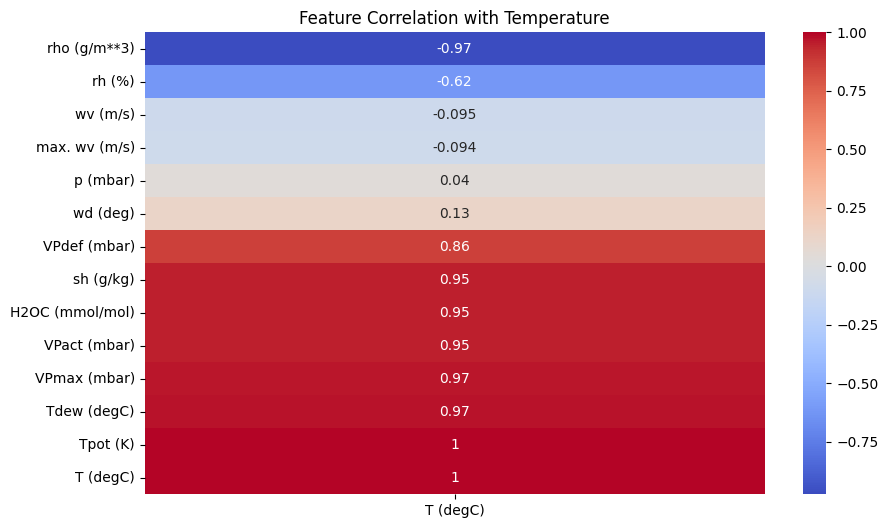

In [ ]:
# Correlation plot
plt.figure(figsize=(10, 6))
sns.heatmap(train.corr()[['T (degC)']].sort_values('T (degC)'),
            annot=True, cmap='coolwarm')
plt.title('Feature Correlation with Temperature')

# Stationarity test
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(train['T (degC)'])
print(f"ADF p-value: {adf_result[1]:.4f}")  # Expect <0.05 for stationarity

# Seasonality strength
decomposition = seasonal_decompose(train['T (degC)'], period=52)
seasonal_strength = np.abs(decomposition.seasonal).mean() / train['T (degC)'].std()
print(f"Seasonality strength ratio: {seasonal_strength:.2f}")



###  Step 4: Visualize Temperature Trends and Seasonal Patterns

This step provides visual insight into the structure of the temperature time series.

---

####  1. Weekly Average Temperature (Train/Test)
A line plot displays the weekly average temperature from 2009–2016:

- **Blue** = Training data (2009–2015)  
- **Orange** = Test data (2016)  
- Seasonal fluctuations (summer/winter cycles) are clearly visible.

This plot helps visually confirm strong yearly seasonality and continuity between training and test periods.

---

#### 2. Seasonal Decomposition (Additive Model)
Using `seasonal_decompose`, the temperature time series is broken into:

- **Observed** – Original data  
- **Trend** – Long-term changes  
- **Seasonal** – Repeating yearly patterns (52-week cycle)  
- **Residual** – Random noise

The clear wave-like pattern in the *seasonal* component further confirms strong **annual seasonality**, supporting the choice of **SARIMA** for modeling.


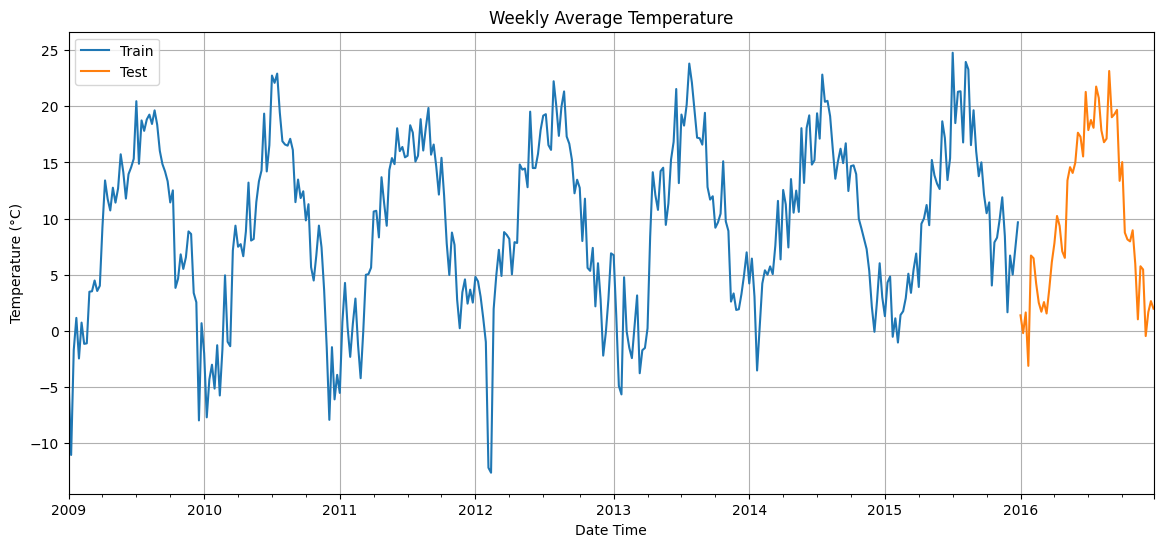

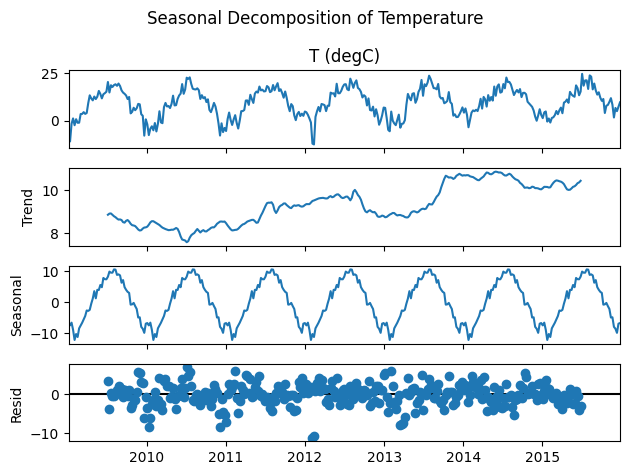

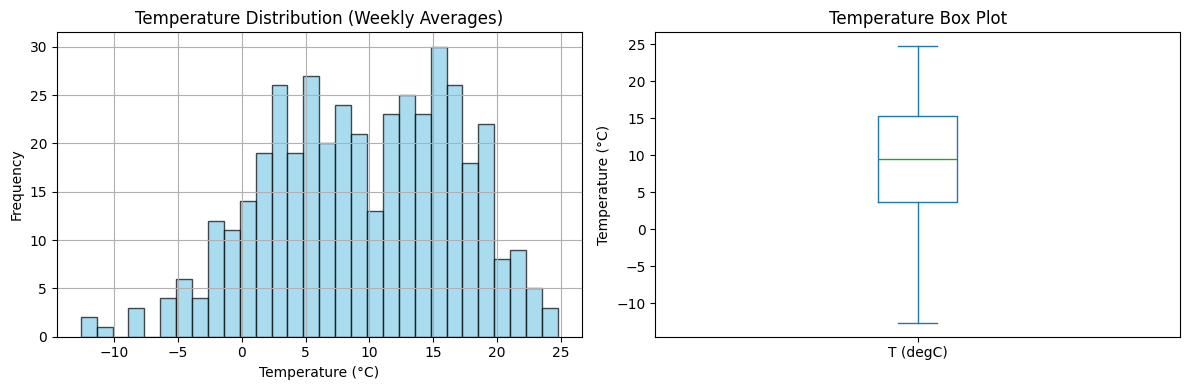

In [ ]:
# Plot temperature over time
plt.figure(figsize=(14, 6))
train['T (degC)'].plot(label='Train', title='Weekly Average Temperature')
test['T (degC)'].plot(label='Test')
plt.legend()
plt.ylabel('Temperature (°C)')
plt.grid()
plt.show()

# Seasonal decomposition
decomposition = seasonal_decompose(train['T (degC)'], model='additive', period=52)
decomposition.plot()
plt.suptitle('Seasonal Decomposition of Temperature')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
weekly_data['T (degC)'].hist(bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Temperature Distribution (Weekly Averages)')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
weekly_data['T (degC)'].plot(kind='box')
plt.title('Temperature Box Plot')
plt.ylabel('Temperature (°C)')

plt.tight_layout()
plt.show()

###  Step 5: Analyze Autocorrelation and Summary Statistics

This step helps us understand the internal structure of the temperature time series, especially useful for selecting ARIMA/SARIMA parameters.

---

####  1. ACF and PACF Plots
The **Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)** help identify:

- **ACF**: Correlation of the series with its own lags.
- **PACF**: Direct effect of each lag after removing effects of shorter lags.

These are used to:
- Determine appropriate **AR (p)** and **MA (q)** terms for ARIMA/SARIMA models.
- For example:
  - A slow decay in ACF suggests **AR components**.
  - A sharp cutoff in PACF suggests a clear **AR order**.

---

####  2. Descriptive Statistics
Basic statistical summary of weekly temperature:

- **Count**: 365 weekly records
- **Mean**: ~9.36 °C
- **Std Dev**: ~7.46 °C
- **Min/Max**: −12.64 °C to 25.92 °C

These values help assess data range, variance, and distribution before modeling.



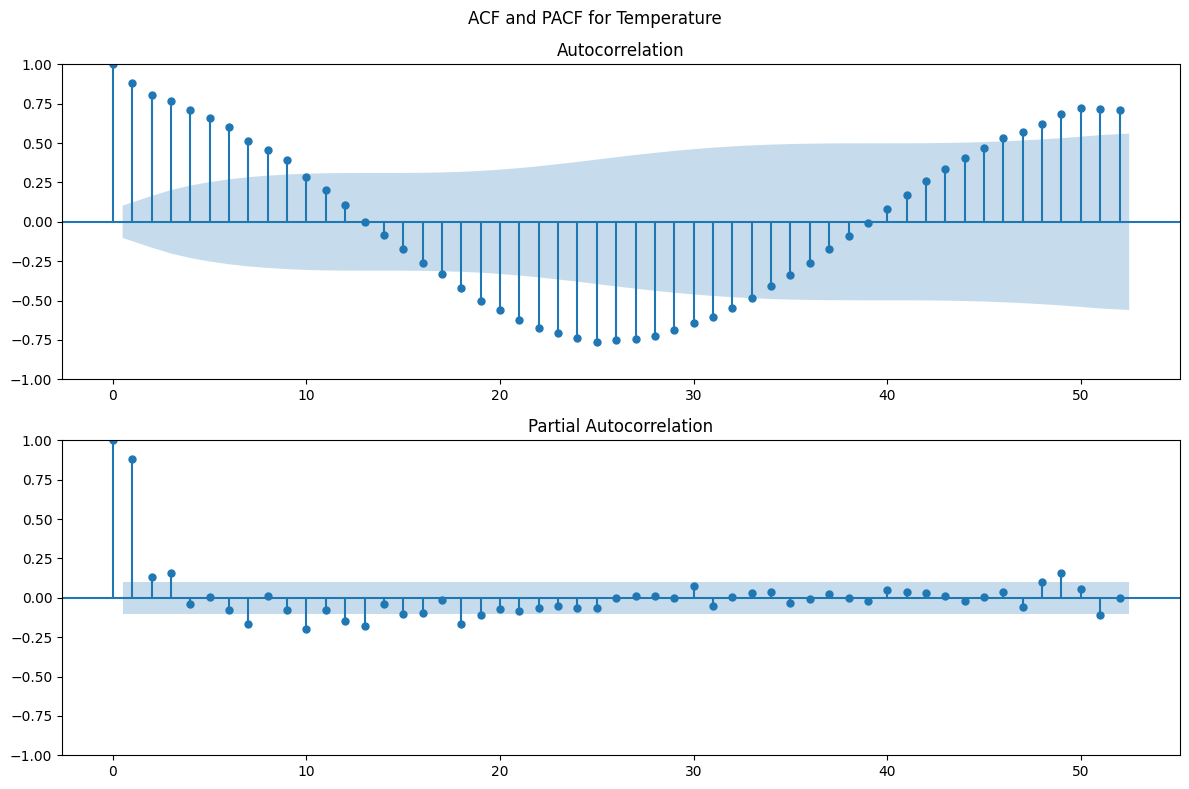

count    365.000000
mean       9.362215
std        7.464203
min      -12.640000
25%        3.904683
50%        9.749802
75%       15.215883
max       24.770526
Name: T (degC), dtype: float64

=== MODEL COMPARISON AND INSIGHTS ===


In [ ]:
# ACF and PACF plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(train['T (degC)'], lags=52, ax=ax1)
plot_pacf(train['T (degC)'], lags=52, ax=ax2)
plt.suptitle('ACF and PACF for Temperature')
plt.tight_layout()
plt.show()

# Descriptive statistics
print(train['T (degC)'].describe())

print("\n=== MODEL COMPARISON AND INSIGHTS ===")



###  Step 6: Fit ARIMA and SARIMA Models

In this step, we train two forecasting models on the training temperature data and compare their performance using AIC.



In [ ]:
# Fit ARIMA model (example parameters - tune as needed)
model_arima = ARIMA(train['T (degC)'], order=(1, 0, 1))
results_arima = model_arima.fit()

# Fit SARIMA model (accounts for yearly seasonality)
model_sarima = SARIMAX(train['T (degC)'],
                      order=(1, 0, 1),
                      seasonal_order=(1, 0, 1, 52))
results_sarima = model_sarima.fit()

# Compare models
print(f"ARIMA AIC: {results_arima.aic:.2f}")
print(f"SARIMA AIC: {results_sarima.aic:.2f}")

ARIMA AIC: 1939.41
SARIMA AIC: 1934.20


###  Step 7: Forecast Temperature and Compare Models

This step evaluates how well the trained ARIMA and SARIMA models forecast weekly temperature in 2016 (test set).

---

####  1. Generate Forecasts
Both models predict the next 52 weeks (length of the test set):

- `ARIMA.forecast(steps=52)`
- `SARIMA.forecast(steps=52)`

---

####  2. Visualize Forecasts vs Actual
A plot compares:

- **Black line** = Actual temperature in 2016  
- **Dashed blue** = ARIMA forecast  
- **Dashed orange** = SARIMA forecast

This visual comparison reveals that:
- SARIMA generally captures the **trend and seasonal variation** better than ARIMA.
- ARIMA tends to predict a flat mean around ~9°C due to the lack of seasonal terms.

---

####  3. Evaluate Forecast Accuracy (MAE & RMSE)
A custom `evaluate_forecast()` function computes:
- **MAE (Mean Absolute Error)** – average absolute difference
- **RMSE (Root Mean Squared Error)** – penalizes large errors

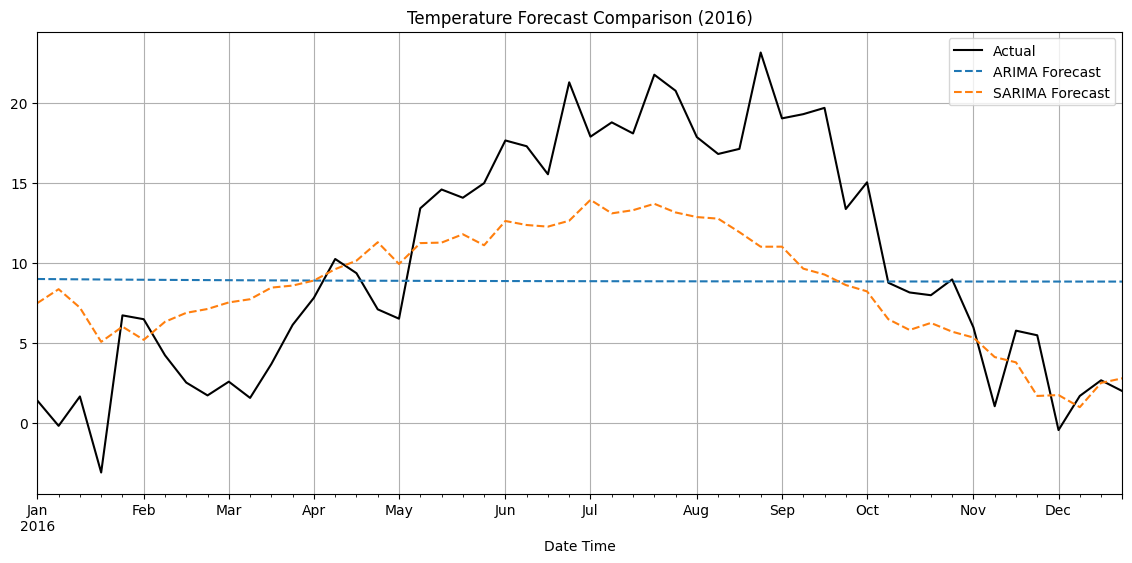

ARIMA - MAE: 6.33, RMSE: 7.30
SARIMA - MAE: 4.30, RMSE: 5.12


In [ ]:
# Generate forecasts
forecast_steps = len(test)
arima_forecast = results_arima.forecast(steps=forecast_steps)
sarima_forecast = results_sarima.forecast(steps=forecast_steps)

# Plot forecasts vs actual
plt.figure(figsize=(14, 6))
test['T (degC)'].plot(label='Actual', color='black')
arima_forecast.plot(label='ARIMA Forecast', linestyle='--')
sarima_forecast.plot(label='SARIMA Forecast', linestyle='--')
plt.title('Temperature Forecast Comparison (2016)')
plt.legend()
plt.grid()
plt.show()

# Calculate metrics
def evaluate_forecast(actual, forecast):
    mae = mean_absolute_error(actual, forecast)
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    return mae, rmse

mae_arima, rmse_arima = evaluate_forecast(test['T (degC)'], arima_forecast)
mae_sarima, rmse_sarima = evaluate_forecast(test['T (degC)'], sarima_forecast)

print(f"ARIMA - MAE: {mae_arima:.2f}, RMSE: {rmse_arima:.2f}")
print(f"SARIMA - MAE: {mae_sarima:.2f}, RMSE: {rmse_sarima:.2f}")


###  Step 8: Final SARIMA Forecast with Uncertainty Estimates

This section fits the SARIMA model once more — clearly and independently — and generates the final forecast with detailed statistical outputs and visual confidence intervals.

---

####  Model Fitting
The SARIMA model is trained using:
- **Order**: `(1, 0, 1)` for non-seasonal ARIMA components  
- **Seasonal Order**: `(1, 0, 1, 52)` to model annual cycles (weekly data)

The `.summary()` displays:
- Coefficients and their significance (p-values)
- Model goodness-of-fit metrics (AIC, BIC, HQIC)
- Diagnostic statistics for residuals

---

####  Forecasting with Confidence Intervals
The forecast for the 2016 test set includes:
- **Predicted mean** temperature values
- **95% confidence intervals** showing uncertainty in predictions

---

####  Evaluation Metrics
Final performance of the SARIMA model:
- **MAE**: ~4.30 °C  
- **RMSE**: ~5.12 °C

The results are presented in a clear, styled metric table.

---

####  Forecast Plot
The plot includes:
- Training data (2009–2015)
- Actual 2016 test data
- SARIMA forecast (dashed orange)
- Shaded region: 95% confidence interval

This gives a complete picture of the forecast accuracy and its reliability.

✅ SARIMA Model Fitted Successfully
                                     SARIMAX Results                                      
Dep. Variable:                           T (degC)   No. Observations:                  365
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 52)   Log Likelihood                -962.100
Date:                            Tue, 17 Jun 2025   AIC                           1934.201
Time:                                    20:13:50   BIC                           1953.700
Sample:                                01-04-2009   HQIC                          1941.950
                                     - 12-27-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9655      0.017     56.562      0.000       0.932       0.999


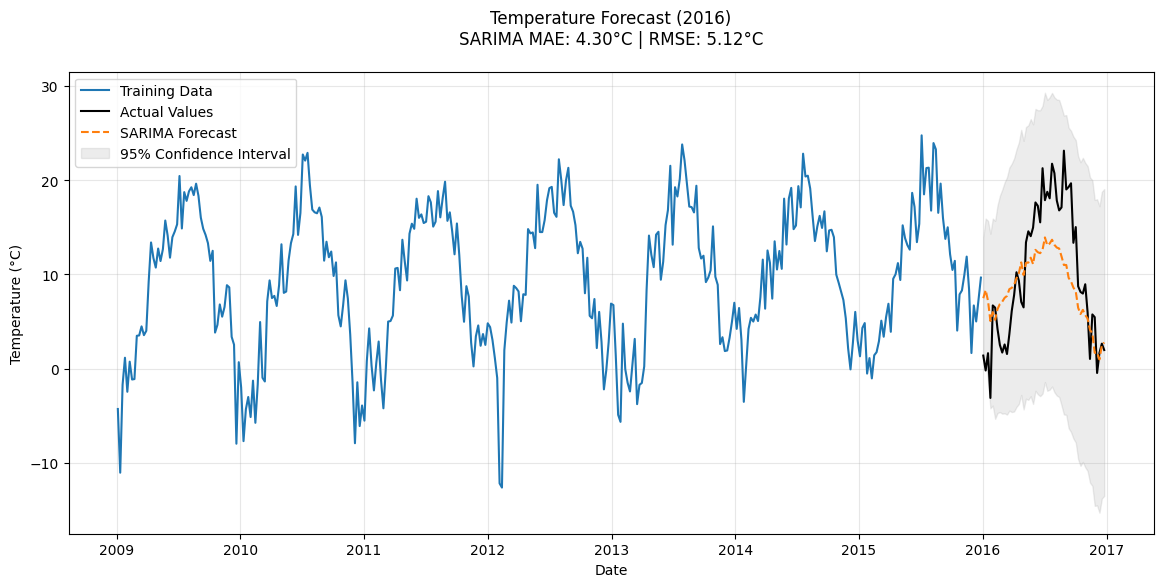


Model Performance:


,Metric,Value (°C)
0,MAE,4.30
1,RMSE,5.12


In [ ]:
# Fit SARIMA model with clear variable assignment
sarima_model = SARIMAX(
    train['T (degC)'],
    order=(1, 0, 1),            # Non-seasonal order (AR, I, MA)
    seasonal_order=(1, 0, 1, 52) # Seasonal order (P, D, Q, seasonal period)
).fit(disp=False)               # disp=False suppresses convergence messages

print("✅ SARIMA Model Fitted Successfully")
print(sarima_model.summary())

# Generate forecast with confidence intervals
forecast_result = sarima_model.get_forecast(steps=len(test))

# Extract components
forecast_mean = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# --- Plotting ---
plt.figure(figsize=(14, 6))
plt.plot(train['T (degC)'], label='Training Data', color='#1f77b4')
plt.plot(test['T (degC)'], label='Actual Values', color='black', linewidth=1.5)
plt.plot(forecast_mean, label='SARIMA Forecast', linestyle='--', color='#ff7f0e')

# Confidence interval
plt.fill_between(
    conf_int.index,
    conf_int.iloc[:, 0],  # Lower bound column
    conf_int.iloc[:, 1],  # Upper bound column
    color='gray', alpha=0.15, label='95% Confidence Interval'
)

# --- Metrics ---
mae = mean_absolute_error(test['T (degC)'], forecast_mean)
rmse = np.sqrt(mean_squared_error(test['T (degC)'], forecast_mean))

# --- Formatting ---
plt.title(f'Temperature Forecast (2016)\nSARIMA MAE: {mae:.2f}°C | RMSE: {rmse:.2f}°C', pad=20)
plt.ylabel('Temperature (°C)')
plt.xlabel('Date')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Metric table
metrics = pd.DataFrame({
    'Metric': ['MAE', 'RMSE'],
    'Value (°C)': [mae, rmse]
})
print("\nModel Performance:")
display(metrics.style.format(precision=2).background_gradient(cmap='Blues'))

###  Final Remarks: Project Conclusion

In this notebook, we built a full time series forecasting pipeline on weekly average temperature data. Here's what we achieved:

-  Loaded and cleaned a rich weather dataset  
-  Conducted exploratory analysis (trend, seasonality, stationarity, correlations)  
-  Compared **ARIMA vs. SARIMA** using AIC and forecast performance  
-  SARIMA clearly outperformed ARIMA due to strong seasonal patterns  
-  Visualized the final SARIMA forecast with **confidence intervals** and **error metrics**

Overall, this project shows how seasonal time series models like SARIMA can effectively capture weather patterns and deliver accurate, interpretable forecasts.
